# Problem Set 2. Part II. Quantative Macroeconomics

### Adam Wilczynski, Alena Sokolyanskaya

The instantanous utility of the individual is now given by

$U(c,n) = log(c) - Г \dfrac{n^{1+\eta}}{1+\eta}$

## [1] Solution of the model without aggregate risk

### [1.1]  Household problem

#### HH problem in a recursive form

The problem of the household is following:

max $\sum_{t=0}^{\infty} \beta^{t} (ln(c_{t}) - Г \dfrac{n_{t}^{1+\gamma}}{1+\gamma}$ 
s.t. $c_{t} = (1+r-\delta) a_{t} + wen - a_{t+1})$

Plugging in the expression for $c_{t}$:

max $\sum_{t=0}^{\infty} \beta^{t} (ln((1+r-\delta) a_{t} + wen - a_{t+1}) - Г \dfrac{n_{t}^{1+\gamma}}{1+\gamma}$

#### Use the intratemporal condition and the budget constraint to write the problem of the household in terms of a single decision variable (savings a').

Taking first order condition wrt $n_{t}$:

$\beta^{t} \dfrac{we}{(1+r-\delta) +wen -a_{t+1}} = \beta^{t} Г n_{t}^{\gamma}$

$ we = Г n_{t}^{\gamma} (1+r-\delta) a_{t} + wen - a_{t+1})$

$a_{t+1}= (1+r-\delta) a_{t} + wen - \dfrac{we}{Г n^{\gamma}}$ 

$ n_{t}- (Г n_{t}^{\gamma})^{-1} = \dfrac{1}{we} (a_{t+1} - (1+r-\delta)a_{t})$

So later solving the model in the code we use following expression:

$ 0 = \dfrac{1}{we} (a_{t+1} - (1+r-\delta)a_{t}) - n_{t} + (Г n_{t}^{\gamma})^{-1}$

#### States of economy
To create new transition matrices, we substract the bloc from our intial transition matrix, and recalculate the probabilities, as following: $П_{new} = \dfrac{П_{gg01}}{П_{gg}}$ for example.

And we got the following transition matrix for good state:
$П_{E}^{good}$ = 
$\begin{bmatrix} 
    0.333 & 0.667 \\
    0.006 & 0.994
    \end{bmatrix}$
    
And transition matrix for bad state:
$П_{E}^{bad}$ = 
$\begin{bmatrix} 
    0.6 & 0.4 \\
    0.023 & 0.977
    \end{bmatrix}$
    
#### General approach

In this case, since we aggregate capital and aggregate labor are invariant, we can avoid using the loop. 

We are also using fixed values for wage and interest rate: w =1 and r = 0.005.
As well as we are abstracting from aggregate risk and fix the TFP $z_{t} = 1$ for all t.

Based on the related literature we fix the parameters $Г = 2 $ and $\gamma = 2$.

In [33]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import random
from scipy.optimize import fsolve

In [34]:
# Transtion matrix aggregate state (unemployment / employment)
# piE good state
piE_good = [ [0.33333333333333337, 0.6666666666666666], 
       [0.005714285714285714, 0.9942857142857143] ] # because average duration of both good and bad times is eight quarters

# piE bad state
piE_bad = [ [0.6, 0.4], 
       [0.022857142857142857, 0.9771428571428571] ]

# Parameters
betta=0.95
delta=0.0025
z=1
alfa=0.36
r = 0.005
w = 1 
GAMMA = 2
gamma = 2

## Grids
# Individual capital
k_grid = np.linspace(1,50,100)
h_grid = np.linspace(0.1, 5.1, 50)

In [35]:
## Starting values for V
def v1g(k):
    return np.log((1+r-delta)*k + w)/(1-betta)     
def v0g(k):
    return np.log((1+r-delta)*k)/(1-betta) 
     


## Evaluation of the VF
def HH_problem(piE):
    # initialize variables
    V1g = [0]*len(k_grid)
    V0g = [0]*len(k_grid)
    V1gt = [0]*len(k_grid)
    V0gt = [0]*len(k_grid)
    h1g = [0]*len(k_grid)
    #h0g = [0]*len(k_grid)
       
    for i in range(len(k_grid)):
            V1g[i]= v1g(k_grid[i])
            V0g[i]= v0g(k_grid[i])
    
    # Solution of the consumer problem
    # Consumption for each possible decision
    # e=0 unemployed =1 employed
    # g=0 good times  =1 bad times
    # consumption
    def c(i,e,g):
        h_dec = [0]*len(k_grid)
        if e == 0:
            vec = (1+r-delta)*k_grid[i]-k_grid
            h_disutility = [0]*len(k_grid)
        else:
            vec = [0]*len(k_grid)
            h_dec = [0]*len(k_grid)
            h_disutility = [0]*len(k_grid)
            for i_prim in range(len(k_grid)):
                h_dec[i_prim] = fsolve(lambda h1: (1/(w*e))*(k_grid[i_prim]-(1+r-delta)*k_grid[i])-h1+1/(GAMMA*h1**gamma), 0.000002)[0]              
                vec[i_prim] = (1+r-delta)*k_grid[i]+w*e*h_dec[i_prim]- k_grid[i_prim]
                h_disutility[i_prim] = GAMMA*h_dec[i_prim]**(1+gamma)/(1+gamma)
        for i in range(len(vec)): 
            if vec[i]<0:
                vec[i]=0
        return  (vec, h_dec, h_disutility)
    
    def column(matrix, i):
        return [row[i] for row in matrix]
    
    iter = 1
    STOP = 0
    while iter < 10 and STOP == 0:
        i=0
        for i in range(len(k_grid)):
            V0gt[i] = max(np.log(c(i,0,0)[0]) + betta*(np.matmul(piE[0],[V0g, V1g])))
            consum, labor, disut = c(i,1,0)
            V1gt[i] = max(np.log(consum)-disut + betta*(np.matmul(piE[1],[V0g, V1g])))
            
        temp=np.array([abs(np.array(V0gt)-np.array(V0g)),abs(np.array(V1gt)-np.array(V1g))])
        dev = temp.max()                
        
        for i in range(len(k_grid)):
            V0g[i]=V0gt[i]
            V1g[i]=V1gt[i]
                
        if dev<0.4:
            STOP = 1
    
        iter = iter + 1
      
    # recover policy function
    a = [0]*len(k_grid)
    for i in range(len(k_grid)):
        a[i]=[0]*2
        for x in range(2):
            a[i][x] = [0]*2
    
    for i in range(len(k_grid)):
        #0g
        a[i][1][0] = np.argmax(np.log(c(i,0,0)[0]) + betta*(np.matmul(piE[0],[V0g, V1g])))
        #1g
        consum, labor, disut = c(i,1,0)
        a[i][0][0] = np.argmax(np.log(consum)-disut + betta*(np.matmul(piE[1],[V0g, V1g])))
        h1g[i] = labor[a[i][0][0]]
               
    ar = np.array(a)  
            
    # recover consumption 
    c = (1+r-delta)*k_grid +w*h1g - k_grid[ar[:,0,0]]
    return(ar, h1g, c)

ar_b, h1b, c_b = HH_problem(piE_bad)
ar_g, h1g, c_g = HH_problem(piE_good)

/Users/alena/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log
/Users/alena/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in log


#### Asset decision for different states of economy

When plotting decision policy in assets for different levels of individual capital, we can notice a slight difference in dynamics for good and bad states.

Asset decision line for both times cross 45 degree line at the value of individual capital approximately equal to 5. whereas line for unemployed agents never cross the line. In bad state of the economy the lines for employed and unemployed individuals have slightly smaller distance between each other compared to good state of economy.


(0, 15)

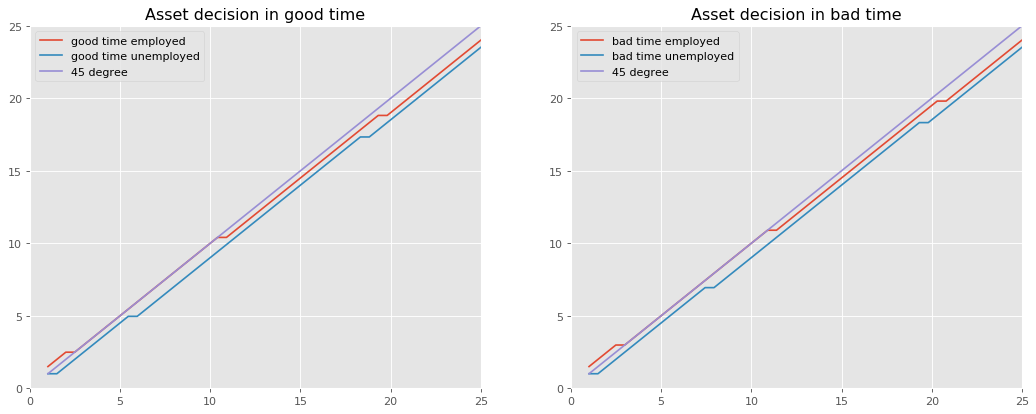

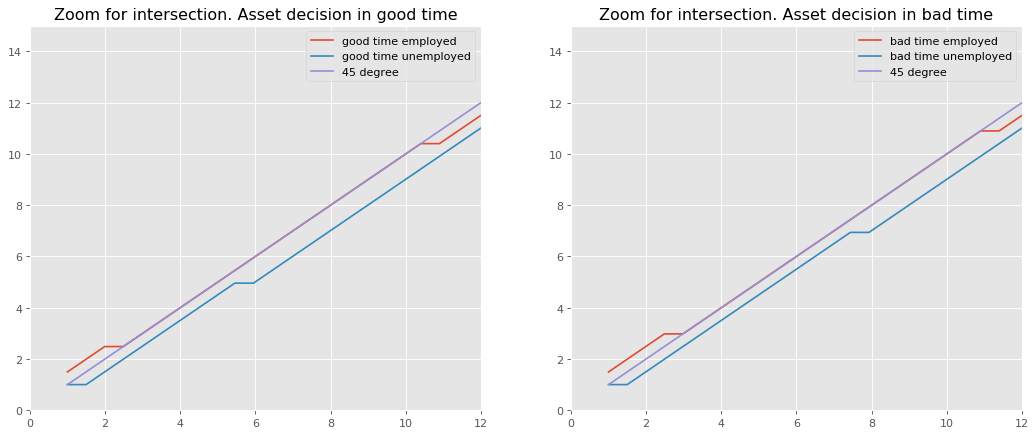

In [43]:
##### plot a' for different values of individual capital. Aggregate capital fixed as 18.48
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.figure(1)

plt.subplot(121)
plt.plot(k_grid, k_grid[ar_g[:,0,0]], label='good time employed')
plt.plot(k_grid, k_grid[ar_g[:,1,0]], label='good time unemployed')
plt.plot(k_grid, k_grid, label='45 degree')
plt.legend()
plt.title('Asset decision in good time')
plt.xlim([0,25])
plt.ylim([0,25])

plt.subplot(122)
plt.plot(k_grid, k_grid[ar_b[:,0,0]], label='bad time employed')
plt.plot(k_grid, k_grid[ar_b[:,1,0]], label='bad time unemployed')
plt.plot(k_grid, k_grid, label='45 degree')
plt.legend()
plt.title('Asset decision in bad time')
plt.xlim([0,25])
plt.ylim([0,25])

#zoom for intersection
figure(num=None, figsize=(16, 14), dpi=80, facecolor='w', edgecolor='k')
plt.figure(2)

plt.subplot(221)
plt.plot(k_grid, k_grid[ar_g[:,0,0]], label='good time employed')
plt.plot(k_grid, k_grid[ar_g[:,1,0]], label='good time unemployed')
plt.plot(k_grid, k_grid, label='45 degree')
plt.legend()
plt.title('Zoom for intersection. Asset decision in good time')
plt.xlim([0,12])
plt.ylim([0,15])

plt.subplot(222)
plt.plot(k_grid, k_grid[ar_b[:,0,0]], label='bad time employed')
plt.plot(k_grid, k_grid[ar_b[:,1,0]], label='bad time unemployed')
plt.plot(k_grid, k_grid, label='45 degree')
plt.legend()
plt.title('Zoom for intersection. Asset decision in bad time')
plt.xlim([0,12])
plt.ylim([0,15])

### Consumption decision

Decision on consumption for different values of individual capital follows upward trend, with bad state line following with a few breaks from the good line.

In good state of economy individuals with lower capital compared to the bad state are able to consume more.

(0, 2)

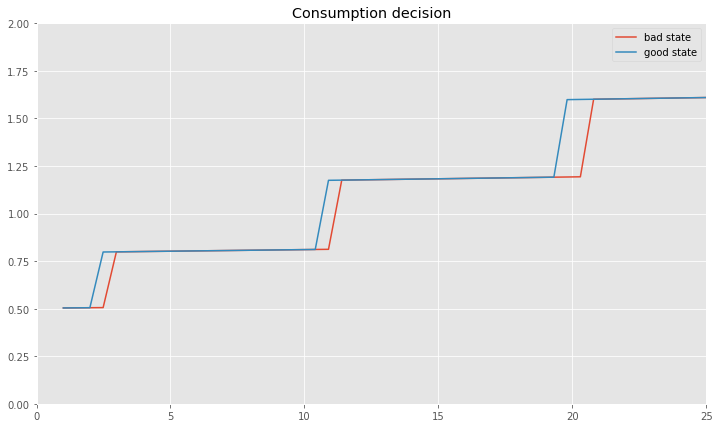

In [44]:
plt.figure(figsize=(12,7))
plt.plot(k_grid, c_b, label='bad state')    
plt.plot(k_grid, c_g, label='good state')
plt.legend()
plt.title('Consumption decision')
plt.xlim([0,25])
plt.ylim([0,2])

### Labor decision

Labor decision (amount hours worked) follows downward slope for the specific values of parameters $Г=2 and \gamma=2$: with higher value of individual capital owned the agent will decide to work less hours. 

Respectively, the lines differ in good and bad states. In bad state individuals need to work more, given same value of the initial capital compared to the good state of the economy. 

(0, 50)

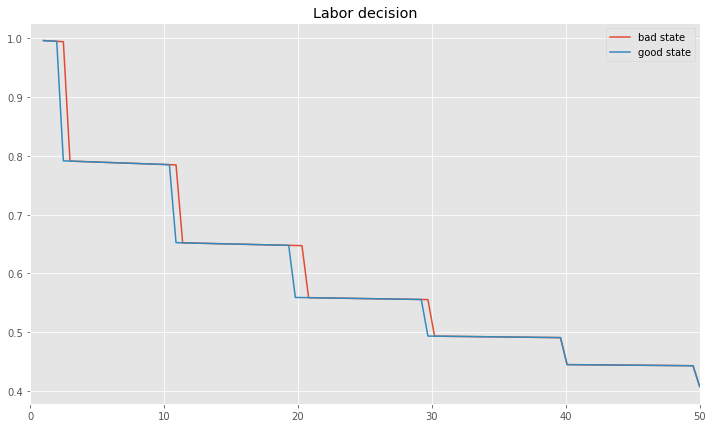

In [45]:
plt.figure(figsize=(12,7))
plt.plot(k_grid, h1b, label='bad state')      
plt.plot(k_grid, h1g, label='good state')  
plt.legend()
plt.title('Labor decision')
plt.xlim([0,50])

#### Plot of both decision policies in one graph for a good state of the economy

Text(0.5,1,'Decisions in good state')

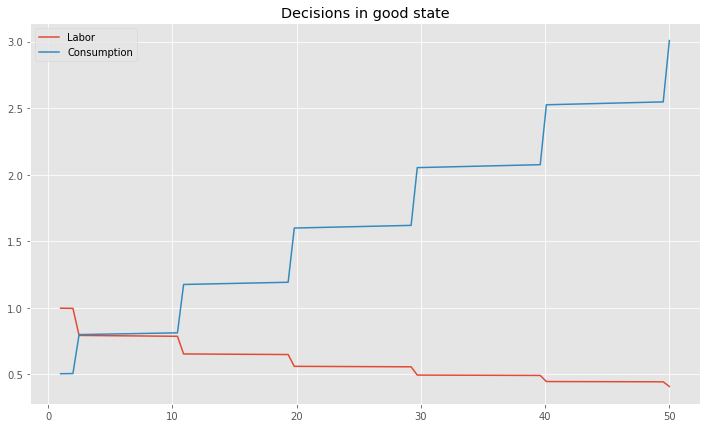

In [46]:
plt.figure(figsize=(12,7))
plt.plot(k_grid, h1g, label='Labor')      
plt.plot(k_grid, c_g, label='Consumption')  
plt.legend()
plt.title('Decisions in good state')
#plt.xlim([0,25])

### [1.2] Equilibrium

#### Making a guess on the level of aggregate capital and aggregate labor.

Our initial guess for the aggregate capital is $K = 1000$ (100 agents x 10 individual capital) and for aggregate labor is $L=40$ (100agents x 0.4 individual decision about labor, assuming all agents are employed), that we approximated to fit our paramters $r=0.005$ and $w=1$, using following formulas:

$r = \alpha \dfrac{K}{L}^{\alpha-1}$
$w = (1-\alpha)\dfrac{K}{L}^\alpha$

At the quilibrium we obtained following values for equilibrium interest rate and wage:

##### In good state of the economy:

Interest rate is equal to  0.0361

Wage is equal to  2.332

##### In bad state of the economy:

Interest rate is equal to  0.036

Wage is equal to 2.35

#### Compare the two equilibria that are implied if you set $z = z_{L}$ and $z = z_{H}$.

We changed our transition probabilities of the employment state and got following result.

In the loop we designed the updating rule and the convergence criteria.
As a result we got the closest almost converged values for the bad state in the 4th interation, when the new value for aggregate capital is equal to 3511.68 and the new value for aggregated labor is equal to 92.

For the good state it almost converged in 7 interations: for aggregate capital is 3562.17, and for aggregate labor is 96. 

In the good state of the economy aggregate capital and labor are bigger then in the bad state of the economy.

##### So finally:

Good state: aggregate capital in good state is 3557.71 and aggregate labor in good state is 98

Bad state: aggregate capital in bad state is 3557.22 and aggregate labor in bad state is 96

#### Calibrate $\gamma$ and $Г$ such that if you average the total labor in the previous two scenarios you get an average of $\dfrac{N_{z_{L}}+ N_{z_{H}}}{2} = \bar N \approx 0.97$

Using parameters $Г = 2 $ and $\gamma = 2$ we obtained correclty calibrated model, as in our case average the total labor in good and bad states is equal to 0.97.

In [47]:
# Evaluation of the VF
def HH_problem_and_EQ(piE):
    #initial guess about aggregate labor and capital
    K = 2700 # 100agents x 27individual capital
    L = 100 # 100agents x 1individual decision about labor, assume all are employed
    betta=0.95
    delta=0.0025
    alfa=0.36
    r = 0.005
    w = 1 
    GAMMA = 2.5
    gamma = 2
    
    BREAK = 0
    iter = 0
    while iter < 10 and BREAK == 0:    
        print(iter)
        r = float(alfa*(K/L)**(alfa-1))
        w = float((1-alfa)*(K/L)**(alfa))
        
        #initialize variables
        V1g = [0]*len(k_grid)
        V0g = [0]*len(k_grid)
        V1gt = [0]*len(k_grid)
        V0gt = [0]*len(k_grid)
        h1g = [0]*len(k_grid)
           
        for i in range(len(k_grid)):
                V1g[i]= v1g(k_grid[i])
                V0g[i]= v0g(k_grid[i])
        
        # Solution of the consumer problem
        # Consumption for each possible decision
        # e=0 unemployed =1 employed
        # g=0 good times  =1 bad times
        #consumption
        def c(i,e,g):
            h_dec = [0]*len(k_grid)
            vec = [0]*len(k_grid)
            if e == 0:
                vec = (1+r-delta)*k_grid[i]-k_grid
                h_disutility = [0]*len(k_grid)
            else:                
                h_dec = [0]*len(k_grid)
                h_disutility = [0]*len(k_grid)
                for i_prim in range(len(k_grid)):
                    h_dec[i_prim] = fsolve(lambda h1: (1/(w*e))*(k_grid[i_prim]-(1+r-delta)*k_grid[i])-h1+1/(GAMMA*h1**gamma), 0.000002)[0]              
                    vec[i_prim] = (1+r-delta)*k_grid[i]+w*e*h_dec[i_prim]- k_grid[i_prim]
                    h_disutility[i_prim] = GAMMA*h_dec[i_prim]**(1+gamma)/(1+gamma)
            for i in range(len(vec)): 
                if vec[i]<0:
                    vec[i]=0
            return (vec, h_dec, h_disutility)
        
        def column(matrix, i):
            return [row[i] for row in matrix]
        
        iter_2 = 0
        STOP = 0
        while iter_2 < 7 and STOP == 0:
            i=0
            for i in range(len(k_grid)):
                V0gt[i] = max(np.log(c(i,0,0)[0]) + betta*(np.matmul(piE[0],[V0g, V1g])))
                consum, labor, disut = c(i,1,0)
                V1gt[i] = max(np.log(consum)-disut + betta*(np.matmul(piE[1],[V0g, V1g])))
            
            temp=np.array([abs(np.array(V0gt)-np.array(V0g)),abs(np.array(V1gt)-np.array(V1g))])
            dev = temp.max()                
            
            for i in range(len(k_grid)):
                V0g[i]=V0gt[i]
                V1g[i]=V1gt[i]
                    
            if dev<0.4:
                STOP = 1
        
            iter_2 = iter_2 + 1
          
        #recover policy function
        a = [0]*len(k_grid)
        for i in range(len(k_grid)):
            a[i]=[0]*2
        
        for i in range(len(k_grid)):
            #0g
            a[i][1] = np.argmax(np.log(c(i,0,0)[0]) + betta*(np.matmul(piE[0],[V0g, V1g])))
            #1g
            consum, labor, disut = c(i,1,0)
            a[i][0] = np.argmax(np.log(consum)-disut + betta*(np.matmul(piE[1],[V0g, V1g])))
            h1g[i] = labor[a[i][0]]
                   
        ar = np.array(a)  
        
        ########## Simulation   
        # A sequence of TFP
        # using the index =0 good ,  =1 bad
        zt = [0]*200          
        zt[0]=0
                                 
        # initial distribution of assets and employment    
        # assets    
        asset = [0]*100
        for n in range(100):
            asset[n]=[0]*200
        #initial asset
        for n in range(100):
            asset[n][0] = 10 # in t=0
        
        #employment
        employ = [0]*100
        for n in range(100):
            employ[n]=[1]*200
         
        #unemployment in t=0  is 7%
        for n in range(100):
            if n<93:
                employ[n][0]=[1]*200    
            else:
                employ[n][0]=[0]*200
        
        #path of employment      
        for n in range(100):
            for t in range(200):            
                if employ[n][t-1]==0:
                    employ[n][t] = int((random.randint(0,100)/100)<=piE[0][1])
                else:
                    employ[n][t] = int((random.randint(0,100)/100)<=piE[1][1])
                    
        #path of asset decision:
        for n in range(100):
            for t in range(200):
                if employ[n][t-1]==0: 
                    dif = abs(k_grid - asset[n][t-1])
                    Ip = np.argmin(dif)
                    asset[n][t] = k_grid[[ar[Ip,1]]]
                else: 
                    dif = abs(k_grid - asset[n][t-1])
                    Ip = np.argmin(dif)
                    asset[n][t] = k_grid[[ar[Ip,0]]]           

        #recover consumption decision
        h1g = np.array(h1g)
        c_emp = (1+r-delta)*k_grid +w*h1g - k_grid[ar[:,0]]
        c_unemp = (1+r-delta)*k_grid - k_grid[ar[:,1]]
        
        #sum K
        K_new=0
        for n in range(100):
            K_new = K_new + asset[n][199]
        K_new = float(K_new)
        #sum L
        L_new=0
        for n in range(100):
            L_new = L_new + employ[n][199]   
            
        if abs(K-K_new)<50 and abs(L-L_new)<5:
            BREAK = 1
            print("K_old: ", K)
            K=K_new
            print("K_new: ", K)
            print("L_old: ", L)
            L=L_new
            print("L_new: ", L)
        else:
            print("K_old: ", K)
            K=K_new
            print("K_new: ", K)
            print("L_old: ", L)
            L=L_new
            print("L_new: ", L)
            iter = iter+1
            
    print("THE END")
    return(ar, h1g, c_emp, c_unemp, asset, employ, K, L)

ar_b, h1b, c_emp_b, c_unemp_b, asset_b, employ_b, K_b, L_b = HH_problem_and_EQ(piE_bad)
ar_g, h1g, c_emp_g, c_unemp_g, asset_g, employ_g, K_g, L_g = HH_problem_and_EQ(piE_good)

0


/Users/alena/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in log
/Users/alena/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log


K_old:  2700
K_new:  4352.111111111108
L_old:  100
L_new:  91
1
K_old:  4352.111111111108
K_new:  3304.797979797977
L_old:  91
L_new:  94
2
K_old:  3304.797979797977
K_new:  3596.32323232323
L_old:  94
L_new:  96
3
K_old:  3596.32323232323
K_new:  3557.2222222222263
L_old:  96
L_new:  96
THE END
0
K_old:  2700
K_new:  4300.141414141418
L_old:  100
L_new:  96
1
K_old:  4300.141414141418
K_new:  3311.7272727272766
L_old:  96
L_new:  99
2
K_old:  3311.7272727272766
K_new:  3662.1515151515127
L_old:  99
L_new:  99
3
K_old:  3662.1515151515127
K_new:  3510.6969696969663
L_old:  99
L_new:  100
4
K_old:  3510.6969696969663
K_new:  3612.656565656571
L_old:  100
L_new:  98
5
K_old:  3612.656565656571
K_new:  3507.7272727272693
L_old:  98
L_new:  97
6
K_old:  3507.7272727272693
K_new:  3557.7171717171736
L_old:  97
L_new:  98
THE END


In [48]:
print('aggregate capital in good state', K_g)
print('aggregate labor in good state', L_g)
print('aggregate capital in bad state', K_b)
print('aggregate labor in bad state', L_b)

aggregate capital in good state 3557.7171717171736
aggregate labor in good state 98
aggregate capital in bad state 3557.2222222222263
aggregate labor in bad state 96


In bad state:

In [49]:
r = float(alfa*(K_b/L_b)**(alfa-1))
w = float((1-alfa)*(K_b/L_b)**(alfa))
print("interest rate is equal to ", r)
print("wage is equal to ", w)

interest rate is equal to  0.035665231884058776
wage is equal to  2.3494288040496767


In good state:

In [50]:
r = float(alfa*(K_g/L_g)**(alfa-1))
w = float((1-alfa)*(K_g/L_g)**(alfa))
print("interest rate is equal to ", r)
print("wage is equal to ", w)

interest rate is equal to  0.03613578390446055
wage is equal to  2.3321705017752445


In [51]:
#average the total labor 
# we get approxametely 0.97
avg_L = (L_b+L_g)/200
print(avg_L)

0.97


#### Asset decision in different states of the economy

In bad state of the economy the lines for employed and unemployed individuals have slightly smaller distance between each other compared to good state of economy.

(30, 50)

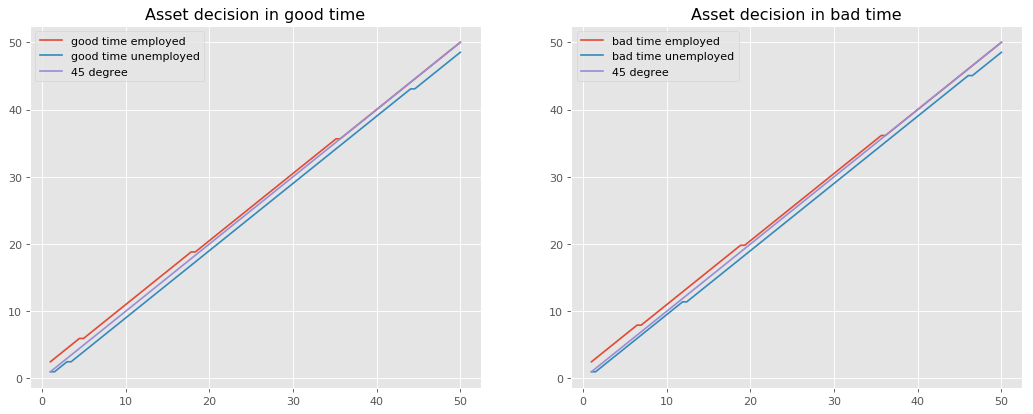

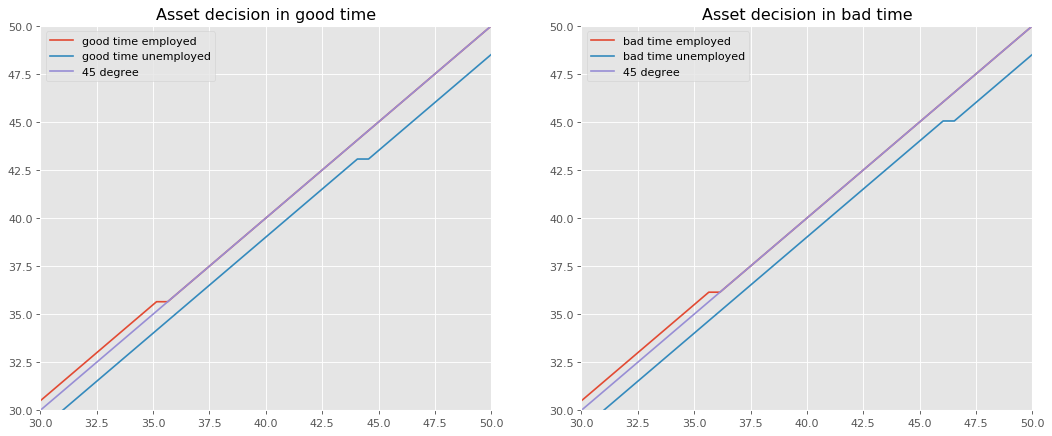

In [54]:
###### plot a' for different values of individual capital. Aggregate capital fixed as 18.48
figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.figure(1)

plt.subplot(121)
plt.plot(k_grid, k_grid[ar_g[:,0]], label='good time employed')
plt.plot(k_grid, k_grid[ar_g[:,1]], label='good time unemployed')
plt.plot(k_grid, k_grid, label='45 degree')
plt.legend()
plt.title('Asset decision in good time')
#plt.xlim([0,25])
#plt.ylim([0,25])

plt.subplot(122)
plt.plot(k_grid, k_grid[ar_b[:,0]], label='bad time employed')
plt.plot(k_grid, k_grid[ar_b[:,1]], label='bad time unemployed')
plt.plot(k_grid, k_grid, label='45 degree')
plt.legend()
plt.title('Asset decision in bad time')
#plt.xlim([0,25])
#plt.ylim([0,25])

#zoom for intersection
figure(num=None, figsize=(16, 14), dpi=80, facecolor='w', edgecolor='k')
plt.figure(2)

plt.subplot(221)
plt.plot(k_grid, k_grid[ar_g[:,0]], label='good time employed')
plt.plot(k_grid, k_grid[ar_g[:,1]], label='good time unemployed')
plt.plot(k_grid, k_grid, label='45 degree')
plt.legend()
plt.title('Asset decision in good time')
plt.xlim([30,50])
plt.ylim([30,50])

plt.subplot(222)
plt.plot(k_grid, k_grid[ar_b[:,0]], label='bad time employed')
plt.plot(k_grid, k_grid[ar_b[:,1]], label='bad time unemployed')
plt.plot(k_grid, k_grid, label='45 degree')
plt.legend()
plt.title('Asset decision in bad time')
plt.xlim([30,50])
plt.ylim([30,50])

### Consumption decision

Decision on consumption for different values of individual capital follows upward trend, with bad state line following with a few breaks from the good line.

In good state of economy individuals with lower capital compared to the bad state are able to consume more.

Text(0.5,1,'Consumption decision')

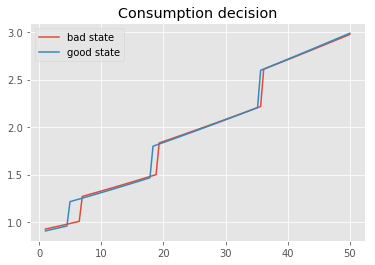

In [55]:
plt.plot(k_grid, c_emp_b, label='bad state')    
plt.plot(k_grid, c_emp_g, label='good state')
plt.legend()
plt.title('Consumption decision') 

### Labor decision

Labor decision (amount hours worked) follows downward slope for the specific values of parameters $Г=2$ and $\gamma=2$: with higher value of individual capital owned the agent will decide to work less hours. 

Respectively, the lines differ in good and bad states. In bad state individuals need to work more, given same value of the initial capital compared to the good state of the economy. 

Text(0.5,1,'Labor decision')

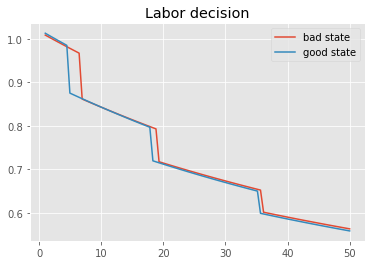

In [56]:
plt.plot(k_grid, h1b, label='bad state')      
plt.plot(k_grid, h1g, label='good state')  
plt.legend()
plt.title('Labor decision')

#### Plot of both decision policies in one graph for a good state of the economy

Text(0.5,1,'Decisions in good state')

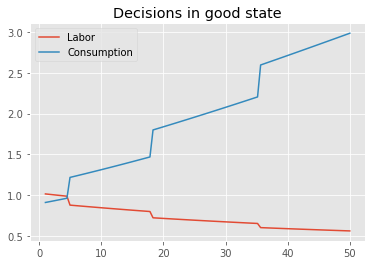

In [57]:
plt.plot(k_grid, h1g, label='Labor')      
plt.plot(k_grid, c_emp_g, label='Consumption')  
plt.legend()
plt.title('Decisions in good state')